In [3]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import binary_accuracy

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

C:\Users\picca\anaconda3\envs\tensor2_GAN_picca\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


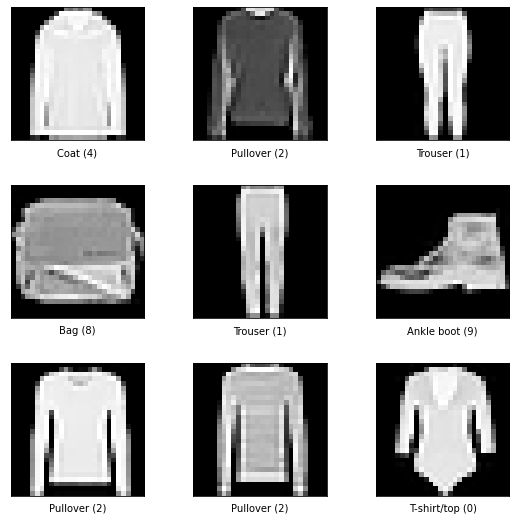

In [4]:
ds_train, ds_info = tfds.load('fashion_mnist', split= 'train', shuffle_files=True, with_info=True)
fig= tfds.show_examples(ds_train, ds_info)
batch_size = 64
image_shape = (32, 32, 1)

In [5]:
def preprocess(features):
    image = tf.image.resize(features['image'], image_shape[:2]) # [:2] h*W [:3] h*W*v
    image = tf.cast(image, tf.float32)
    image = (image-127.5) / 127.5
    return image

In [6]:
ds_train = ds_train.map(preprocess)
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size, drop_remainder=True).repeat()

In [7]:
# print(ds_info)
# print(ds_info.splits['train'])
train_num = ds_info.splits['train'].num_examples

In [8]:
train_steps_per_epoch = round(train_num/batch_size)
print(train_steps_per_epoch)

938


In [9]:
""" 
WGAN 
"""
class WGAN():
    def __init__(self, input_shape):
        self.z_dim = 128
        self.input_shape = input_shape

        # losses
        self.loss_critic_real = {}
        self.loss_critic_fake = {}
        self.loss_critic = {}
        self.loss_generator = {}

        # critic
        self.n_critic = 5
        self.critic = self.build_critic()
        self.critic.trainable = False
        self.optimizer_critic =  RMSprop(5e-5)

        # build generator pipeline  with frozen critic
        self.generator = self.build_generator()
        critic_output = self.critic(self.generator.output)
        self.model = Model(self.generator.input, critic_output)
        self.model.compile(loss=self.wasserstein_loss, optimizer=RMSprop(5e-5))
        self.critic.trainable = True

    def wasserstein_loss(self, y_true, y_pred):
        w_loss = -tf.reduce_mean(y_true*y_pred)
        return w_loss

    # generator model
    def buid_generator(self):
        DIM = 128
        model = tf.keras.Sequential(name= 'Generator')

        model.add(layers.Input(shape=[self.z_dim]))

        model.add(layers.Dense(4*4*4*DIM))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())
        model.add(layers.Reshape(4, 4, 4*DIM))

        model.add(layers.UpSampling2D((2,2), interpolation="bilinerar"))
        model.add(layers.Conv2D(2*DIM, 5, padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())

        model.add(layers.UpSampling2D((2,2), interpolation="bilinerar"))
        model.add(layers.Conv2D(DIM, 5, padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())

        model.add(layers.UpSampling2D((2, 2), interpolation="bilinerar"))
        model.add(layers.Conv2D(image_shape[-1], 5, padding='same', activation='tanh'))
        return model

    # critic model/descriminator model
    def build_critic(self):
        DIM = 128
        model = tf.keras.Sequential(name= 'critics')
        
        model.add(layers.Input(shape=self.input_shape))

        model.add(layers.Conv2D(1*DIM, 5, strides=2, padding='same'))
        model.add(layers.LeakyReLU(0.2))

        model.add(layers.Conv2D(2*DIM, 5, strides=2, padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU(0.2))

        model.add(layers.Conv2D(4*DIM, 5, strides=2, padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU(0.2))

        model.add(layers.Flatten())
        model.add(layers.Dense(1))

        return model








          